In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

/Users/jcolamendy/python/tutorials/ml-tutorials/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load dataset
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


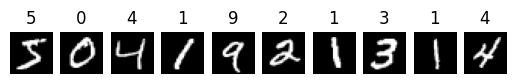

In [3]:
# show images and labels
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

In [4]:
# flatten the image into rows: 28 x 28 = 784
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


In [5]:
# normalize the pixel values to a range between 0 and 1 (instead of 0 to 255)
# min-max normalization formula: X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# for images: X_train = X_train / 255.0
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [8]:
# build generation function
# a positive pair consists of two images representing the same digit, 
# while a negative pair consists of two images representing different digits.
import numpy as np

def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [9]:
# generate train and test pairs
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


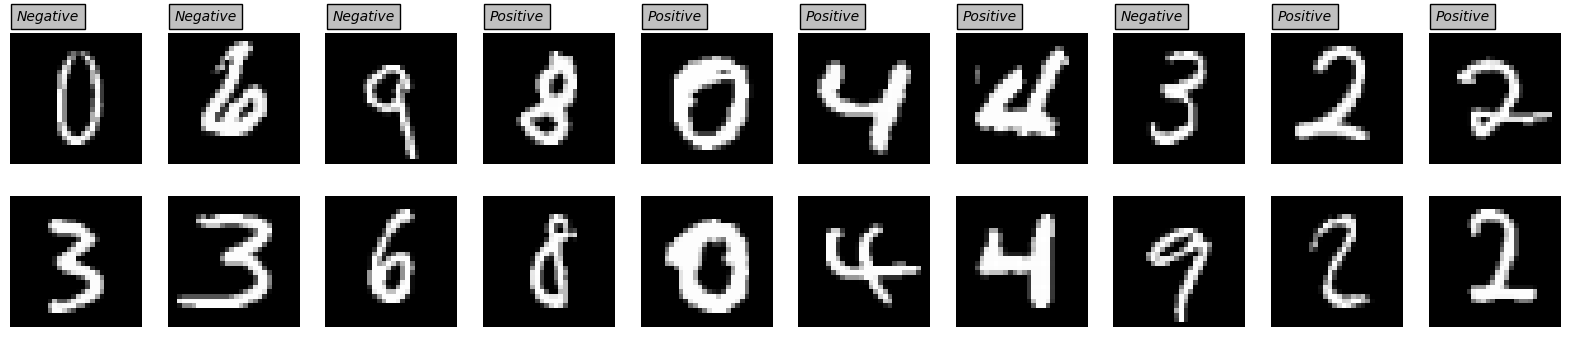

In [10]:
# display pairs
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

In [11]:
# build the network
from keras import Input

from keras.layers import Dense
from keras.models import Sequential

from keras.layers import Lambda
from keras.ops import norm

from keras import Model

# input
input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

# body of the Siamese Network
network = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation=None),
    ]
)
# network will have two branches, each one responsible for processing one of the images in the pair. 
# the network weights are shared because the network instance is the same
twin1 = network(input1)
twin2 = network(input2)
# output of the Siamese Network will be the distance between the embeddings of the two images.
# use a Lambda layer to calculate the Euclidean distance between the embeddings.
def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)

# lambda layer is layer to run a function for you
distance = Lambda(euclidean_distance)([twin1, twin2])
# set up the model
model = Model(inputs=[input1, input2], outputs=distance)

In [12]:
# define the loss function
# use Contrastive Loss to train the model
from keras.ops import cast, maximum, square

def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """
    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

In [13]:
# compile the model using the constrative loss function 
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [15]:
# train the model
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - binary_accuracy: 0.8813 - loss: 0.0524 - val_binary_accuracy: 0.9520 - val_loss: 0.0233
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - binary_accuracy: 0.9654 - loss: 0.0198 - val_binary_accuracy: 0.9636 - val_loss: 0.0197
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - binary_accuracy: 0.9785 - loss: 0.0146 - val_binary_accuracy: 0.9643 - val_loss: 0.0188
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - binary_accuracy: 0.9848 - loss: 0.0117 - val_binary_accuracy: 0.9641 - val_loss: 0.0178
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - binary_accuracy: 0.9889 - loss: 0.0097 - val_binary_accuracy: 0.9672 - val_loss: 0.0172


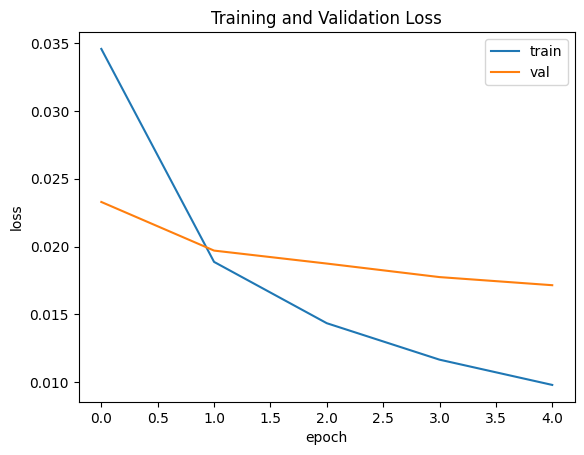

In [16]:
# plot the learning curve
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(20000, 1)
[[0.26150796]
 [0.13934597]
 [0.08228049]
 [1.066666  ]
 [0.9239189 ]
 [1.0259738 ]
 [1.289116  ]
 [1.4354179 ]
 [0.0380861 ]
 [0.83036697]]
(20000, 1)
[[False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]]


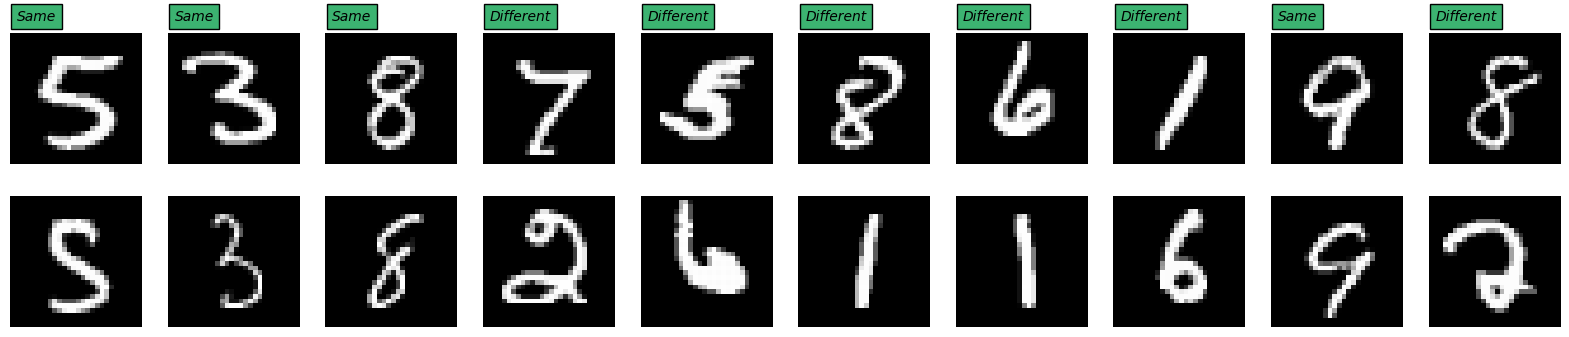

In [19]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]])
print(predictions.shape)
print(predictions[:10])

threshold_predictions = predictions >= 0.5
print(threshold_predictions.shape)
print(threshold_predictions[0:10])

display_pairs(X_test_pairs, threshold_predictions, threshold_predictions == y_test_pairs)

In [20]:
# compute the accuracy of the model
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.87


In [21]:
# print out the model
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [22]:
# get the embedding / sequential model in this case
embedding_model = model.layers[2]

In [23]:
# two random images representing the digit 3, and one image representing the digit 7
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(573, 3715, 5560)

In [25]:
# compute the embedding for each digit
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [26]:
# compute distance for digit 3
# close to zero
norm(embedding1 - embedding2).numpy()

0.11132759

In [27]:
# compute the distance between digit 3 and digit 7
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()

(1.6657107, 1.5550356)

In [29]:
arr = np.array([0,1,2,3,4,5,6,7,8,9])
print(arr)
print(type(arr))

[0 1 2 3 4 5 6 7 8 9]
<class 'numpy.ndarray'>


In [33]:
cond = arr <=5
print(cond)
print(type(cond))
res = arr[cond]
print(res)
print(type(res))

[ True  True  True  True  True  True False False False False]
<class 'numpy.ndarray'>
[0 1 2 3 4 5]
<class 'numpy.ndarray'>


In [38]:
indexes = np.where(arr <= 5)[0]
print(indexes)
print(type(indexes))
res = arr[indexes]
print(res)
print(type(res))

[0 1 2 3 4 5]
<class 'numpy.ndarray'>
[0 1 2 3 4 5]
<class 'numpy.ndarray'>
